# Ex. 01:  Kalman Filter


### A. Bayes Rule
Use the Bayes rule 
$$P(A|B)= \frac{P(B|A)P(A)}{P(B)}$$
to solve following problem:

  Last year 100 students have taken the exam in mathematics.
  50 of them passed the exam. 42 out of these 50 have been doing homeworks.
  There is only one student who did the homeworks but failed the exam.
  
  
**Task**
1.   Find the probability for a student to pass the exam, given he has done all the homeworks. Therefore, solve the following tasks:
    1. Name each of the probabilities $[P(A|B),P(B|A),P(A),P(B)]$ in the context of this task. (2 Points)
      - E.g. P(A|B)= Probabilitiy of ... given ...
    2. Compute the probability for the given values. (2 Points)
### B. Kalman Filter
In the lecture you got to know the Kalman Filter as a realization of the Bayes filter where you assume a linear model and gaussian distributed noise. In this exercise, you need to estimate the height and velocity of a falling object in ${R}^1$ recursively for specific time intervals of $t=1$ seconds.

Assume the initial state of the object to be given by its height $y=95.5$ m and velocity $v=0$ $\frac{m}{s}$ and corresponding uncertainties $\sigma_y^2=0.25$ and $\sigma_v^2=0.05$. We assume a motion with uniform acceleration of $a=1$ $\frac{m}{s^2}$ which we will treat as a control command. In addition, you observe the height of the falling object for five consecutive time steps $z = [96.4, 95.9, 94.4, 87.7, 85.3]$ m with $\sigma_z^2=0.5$.
The covariance of the process noise is given as follwing: 
    $${\Sigma}_t = \begin{pmatrix} 0.1 & 0 \\ 0 & 0.1 \end{pmatrix}$$

**Tasks:**
2. What are the unknows of your state vector $\mathbf{x}_t$? (1 Point)
3. Write down the linear model $\mathbf{x}_t=\mathbf{A}_t\mathbf{x}_{t-1} + \mathbf{B}_t \mathbf{u}_t$ explicitly and print the matrices $\mathbf{A}_t$, $\mathbf{B}_t$ to the terminal. (3 Points)
4. Write down the linear model $\mathbf{z}_t=\mathbf{C}_t \mathbf{x}_t$ explicitly and print the matrix $\mathbf{C}_t$ to the terminal. (2 Points)
5. Recursively estimate the state $\mathbf{x}_t$ of the falling object for five consecutive time steps according to the Kalman Filter.
For each time step visualize the predicted heigth of $\bar{\mathbf{x}}_t$, the observation $\mathbf{z}_t$ and the posteriori state estimate $\mathbf{x}_t$. Plot time steps on the x-axis and height on the y-axis. (6)
6. Assume the measurements of your sensor to be unreliable. This time set the uncertainty $\sigma_z^2=1e^8$ and recursively estimate the state. Visualize your results and explain the behaviour of the Kalman Filter. (2 Points)
7. Assume the measurements of your sensor to be nearly perfect. This time set the uncertainty $\sigma_z^2=1e^{-8}$ and recursively estimate the state. Visualize your results and explain the behaviour of the Kalman Filter. (2 Points)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Optional

@dataclass
class BayesianData:
    """Container for Bayesian probability data"""
    total_students: int
    passed_students: int
    passed_and_homework: int
    failed_but_homework: int

@dataclass
class KalmanParameters:
    """Container for Kalman filter parameters"""
    time_step: float
    acceleration: float
    P: np.ndarray  
    Q: np.ndarray  
    R: np.ndarray  

In [8]:
class BayesianAnalyzer:
    """Handles Bayesian probability calculations"""
    
    def __init__(self, data: BayesianData):
        self.data = data
        self._validate_data()
        
    def _validate_data(self) -> None:
        """Validate input data"""
        if self.data.total_students <= 0:
            raise ValueError("Total students must be positive")
        if self.data.passed_students > self.data.total_students:
            raise ValueError("Passed students cannot exceed total")
            
    def calculate_probabilities(self) -> dict:
        """Calculate all Bayesian probabilities"""
        p_a = self.data.passed_students / self.data.total_students
        p_b = (self.data.passed_and_homework + self.data.failed_but_homework) / self.data.total_students
        p_b_given_a = self.data.passed_and_homework / self.data.passed_students
        p_a_given_b = (p_b_given_a * p_a) / p_b
        
        return {
            'P(A)': p_a,
            'P(B)': p_b,
            'P(B|A)': p_b_given_a,
            'P(A|B)': p_a_given_b
        }

class KalmanFilter:
    """Implements Kalman filter for trajectory estimation"""
    
    def __init__(self, params: KalmanParameters):
        self.params = params
        self.C = np.array([[1, 0]])  # Measurement matrix
        
    def _get_state_matrix(self, t: float) -> np.ndarray:
        """Calculate state transition matrix"""
        return np.array([[1, t],
                        [0, 1]])
        
    def _get_input_matrix(self, t: float) -> np.ndarray:
        """Calculate input matrix"""
        return np.array([[0.5 * t**2],
                        [t]])
        
    def filter(self, x_init: np.ndarray, measurements: List[float]) -> Tuple[List[float], List[float]]:
        """
        Apply Kalman filter to measurements
        
        Args:
            x_init: Initial state vector [position, velocity]
            measurements: List of position measurements
            
        Returns:
            Tuple of (estimated heights, predicted heights)
        """
        x = x_init
        P = self.params.P
        pred_height = []
        height = []
        u_t = np.array([[self.params.acceleration]])

        for t in range(1, len(measurements) + 1):
            # Prediction step
            A = self._get_state_matrix(t)
            B = self._get_input_matrix(t)
            x_prime = np.dot(A, x) + np.dot(B, u_t)
            P_prime = np.dot(np.dot(A, P), A.T) + self.params.Q
            pred_height.append(x_prime[0][0])

            # Update step
            Z = np.array([[measurements[t-1]]])
            y = Z - np.dot(self.C, x_prime)
            S = np.dot(self.C, np.dot(P_prime, self.C.T)) + self.params.R
            K = np.dot(np.dot(P_prime, self.C.T), np.linalg.inv(S))

            x = x_prime + np.dot(K, y)
            P = np.dot((np.eye(2) - np.dot(K, self.C)), P_prime)
            height.append(x[0][0])

        return height, pred_height

class Visualizer:
    """Handles plotting of Kalman filter results"""
    
    @staticmethod
    def plot_trajectory(heights: List[float], pred_heights: List[float], 
                       measurements: List[float], title: str) -> None:
        """Plot actual vs predicted trajectory"""
        x = np.array(range(1, len(heights) + 1))
        
        plt.figure(figsize=(10, 6))
        plt.plot(x, heights, '-g', label="estimated height")
        plt.plot(x, pred_heights, '-.y', label="predicted height")
        plt.plot(x, measurements, '.r', label="observations")
        
        plt.legend(loc="upper left")
        plt.xlabel("Time in seconds")
        plt.ylabel("Distance in metres")
        plt.title(title)
        plt.grid(True)
        plt.show()



Bayesian Analysis Results:
P(A) = 0.500 (50.0%)
P(B) = 0.430 (43.0%)
P(B|A) = 0.840 (84.0%)
P(A|B) = 0.977 (97.7%)


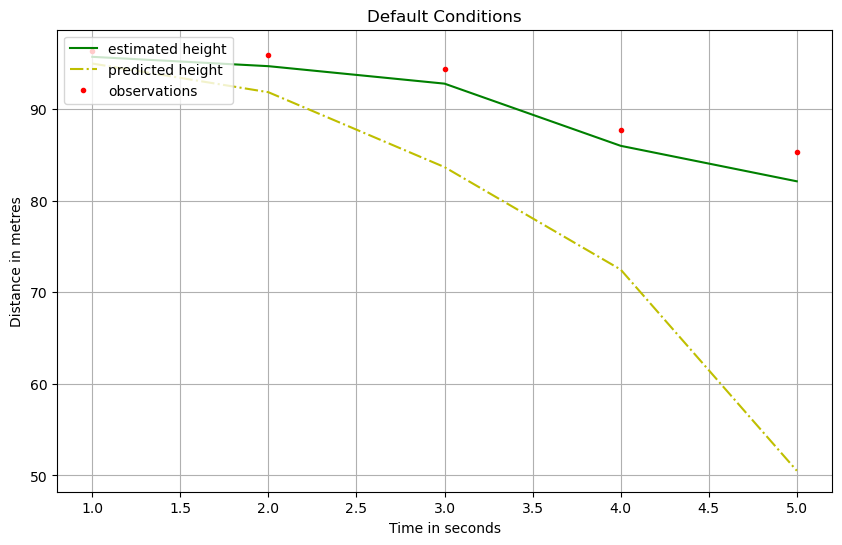

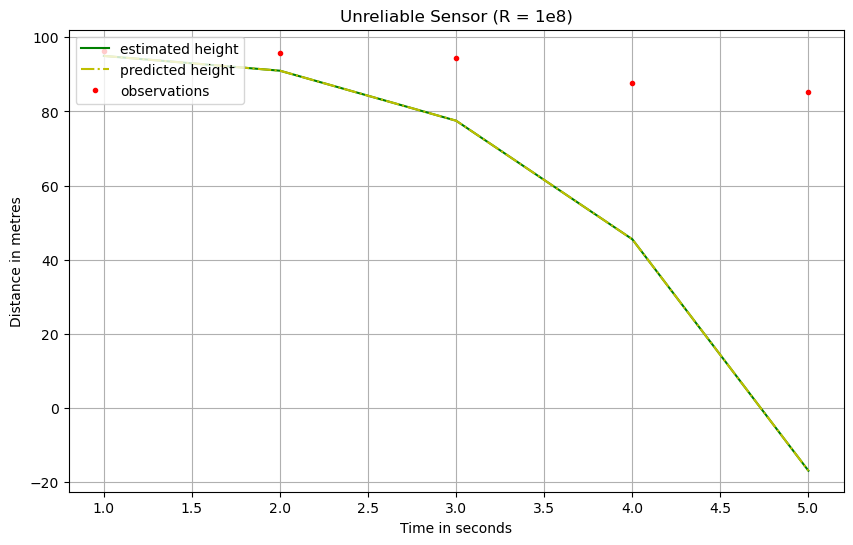

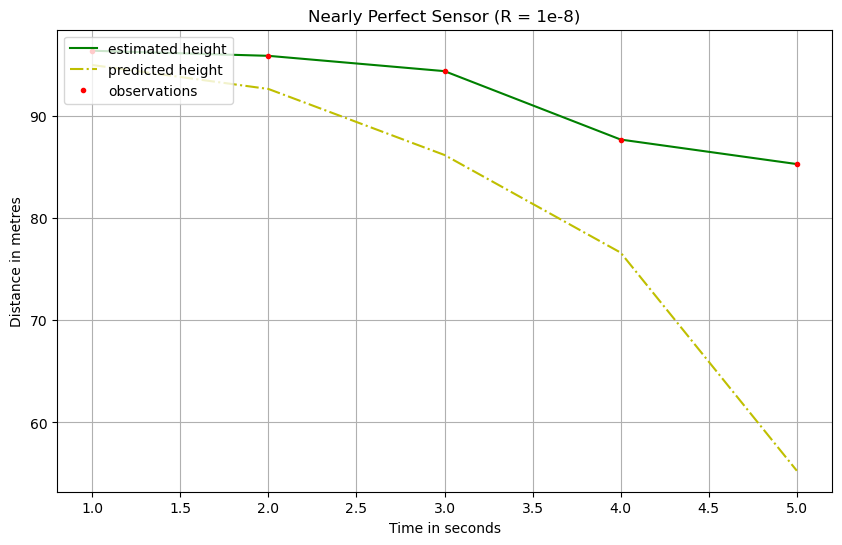

In [11]:
# Bayesian Analysis
bayes_data = BayesianData(
    total_students=100,
    passed_students=50,
    passed_and_homework=42,
    failed_but_homework=1
)
    
analyzer = BayesianAnalyzer(bayes_data)
probabilities = analyzer.calculate_probabilities()
    
print("\nBayesian Analysis Results:")
for key, value in probabilities.items():
    print(f"{key} = {value:.3f} ({value*100:.1f}%)")
 
# Kalman Filter Analysis
params = KalmanParameters(
    time_step=1,
    acceleration=-1,
    P=np.array([[0.25, 0], [0, 0.05]]),
    Q=np.array([[0.25, 0], [0, 0.1]]),
    R=np.array([[0.5]])
)
    
kf = KalmanFilter(params)
x_init = np.array([[95.5, 0]]).T
measurements = [96.4, 95.9, 94.4, 87.7, 85.3]
    
# Default case
height, pred_height = kf.filter(x_init, measurements)
Visualizer.plot_trajectory(height, pred_height, measurements, "Default Conditions")
    
# Unreliable sensor case
params_unreliable = KalmanParameters(**{**params.__dict__, 'R': np.array([[1e8]])})
kf_unreliable = KalmanFilter(params_unreliable)
height_unreliable, pred_height_unreliable = kf_unreliable.filter(x_init, measurements)
Visualizer.plot_trajectory(height_unreliable, pred_height_unreliable, 
                         measurements, "Unreliable Sensor (R = 1e8)")
    
# Perfect sensor case
params_perfect = KalmanParameters(**{**params.__dict__, 'R': np.array([[1e-8]])})
kf_perfect = KalmanFilter(params_perfect)
height_perfect, pred_height_perfect = kf_perfect.filter(x_init, measurements)
Visualizer.plot_trajectory(height_perfect, pred_height_perfect, 
                         measurements, "Nearly Perfect Sensor (R = 1e-8)")

# Bayesian and Kalman Filter Analysis Tool

## Overview
This excersice combines Bayesian probability analysis with Kalman filtering to provide a comprehensive tool for analyzing student performance data and trajectory estimation. It features a modular design with separate components for Bayesian analysis, Kalman filtering, and visualization.

## Table of Contents
- [Installation](#installation)
- [Usage](#usage)
- [Components](#components)
- [Theory](#theory)
- [Examples](#examples)

## Installation

### Prerequisites
- Python 3.8+
- NumPy
- Matplotlib

### Setup
```bash
# Install required packages
pip install numpy matplotlib
```

## Usage

### Basic Usage
```python
# Bayesian Analysis
bayes_data = BayesianData(
    total_students=100,
    passed_students=50,
    passed_and_homework=42,
    failed_but_homework=1
)
analyzer = BayesianAnalyzer(bayes_data)
probabilities = analyzer.calculate_probabilities()

# Kalman Filter
params = KalmanParameters(
    time_step=1,
    acceleration=-1,
    P=np.array([[0.25, 0], [0, 0.05]]),
    Q=np.array([[0.25, 0], [0, 0.1]]),
    R=np.array([[0.5]])
)
kf = KalmanFilter(params)
```

## Components

### BayesianAnalyzer
Handles probability calculations for student performance analysis:
- Calculates P(A): Probability of passing
- Calculates P(B): Probability of doing homework
- Calculates P(B|A): Probability of homework given passing
- Calculates P(A|B): Probability of passing given homework

### KalmanFilter
Implements the Kalman filter algorithm for trajectory estimation:
- Prediction step using state transition model
- Update step using measurements
- Configurable noise parameters
- Support for different sensor reliability scenarios

### Visualizer
Provides visualization tools for Kalman filter results:
- Plots estimated trajectory
- Plots predicted trajectory
- Plots actual measurements
- Customizable plot styling

## Theory

### Bayesian Analysis
The Bayesian analysis component uses Bayes' theorem:

P(A|B) = P(B|A) * P(A) / P(B)

Where:
- A is the event of passing
- B is the event of doing homework
- P(A|B) is the probability of passing given homework completion

### Kalman Filter
The Kalman filter implements a two-step process:

1. Prediction Step:
   ```
   x' = Ax + Bu
   P' = APA^T + Q
   ```

2. Update Step:
   ```
   y = z - Cx'
   S = CP'C^T + R
   K = P'C^T S^-1
   x = x' + Ky
   P = (I - KC)P'
   ```

Where:
- x is the state vector
- P is the error covariance
- Q is the process noise covariance
- R is the measurement noise covariance

## Examples

### Student Performance Analysis
```python
# Example of analyzing student performance
bayes_data = BayesianData(
    total_students=100,
    passed_students=50,
    passed_and_homework=42,
    failed_but_homework=1
)
analyzer = BayesianAnalyzer(bayes_data)
results = analyzer.calculate_probabilities()
```

### Trajectory Estimation
```python
# Example of trajectory estimation with different sensor reliabilities
measurements = [96.4, 95.9, 94.4, 87.7, 85.3]
x_init = np.array([[95.5, 0]]).T

# Default case
height, pred_height = kf.filter(x_init, measurements)
Visualizer.plot_trajectory(height, pred_height, measurements, "Default Conditions")
```

# Exercise 2 - EKF Localization

In this assignment you need to implement an EKF algorithm for localizing a robot in a given landmark map. 
The data for this exercise is recorded on a differential drive robot equipped with a sensor able to detect the distance and the angle of landmarks (e.g., beacons). The figure below visualizes the landmark map and the actual trajectory (ground truth) taken by the robot.

In [66]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ex6 import *
%matplotlib inline

# read dataset
data = pickle.load(open("dataset_2d_landmarks.p", "rb"))

# get landmark coordinates 
M = data['M']

# get ground truth trajectory
gt_traj = data['gt']

# show map
plt.figure(1)
plt.plot(M[:,0], M[:,1], '^r')

# show ground truth trajectory
for i in range(0,len(gt_traj),10):
    plt.plot(gt_traj[i][0],gt_traj[i][1], '.b')


The following data is provided in `data`:

- *M* is the map of the environment where the robot must localize
- *odom* is the noisy odometry readings observed by the robot during navigation in the form: $\hat{x}_t,\hat{y}_t, \hat{\theta}_t$ in the odometry frame
- *gt* is the ground truth trajectory (poses in the map frame), you may want to use it for checking your results
- *z* are the sensor measurements

Each measurement $z_t$ contains a set of observed landmarks $[\rho_i; \phi_i; id_i]$, where $\rho_i$ is the measured distance, $\phi_i$ is the measured angle, and $id_i$ is the id of the landmark.

You can access the `data` as follows:

In [67]:
# get odomety at timestamp 10
odom_10 = data['odom'][10]
print("Odom at step 10 is: \n",odom_10)

# get observation at timestamp 10
z_10 = data['z'][10]
print("Observation at step 10 is: \n",z_10)

Odom at step 10 is: 
 [ 0.3449921   0.00058428 -0.02110238]
Observation at step 10 is: 
 [[ 2.1793557   1.27533718  3.5604415 ]
 [ 2.92652148 -1.4372858   0.4519207 ]
 [ 4.         11.         14.        ]]


## 6.1 Prediction [3.0]

The `ekf_predict` function computes a prediction about the robot's pose after moving by using the odometry motion model.

It takes as input:

- the current belief about the pose of the robot represented as a Gaussian distribution $\mathcal{N}(\mu_t,\Sigma_t)$ 
- the odometry readings $u_t$

The output is a prediction about the robot's pose $\mathcal{N}(\overline{\mu}_{t+1},\overline{\Sigma}_{t+1})$.

You can use your implementation of the `inverse_motion_model` function from Exercise 3 to compute the $u_t = [\delta_{rot1}, \delta_{trans}, \delta_{rot2}]$  from the odometry information.

Implement the `ekf_predict` function and verify that it is correct for some test input. 

In [71]:
import numpy as np
from math import atan2, sqrt

def wrap_to_pi(theta):
    """Wrap angle to the range [-pi, pi]."""
    while theta < -np.pi:
        theta += 2 * np.pi
    while theta > np.pi:
        theta -= 2 * np.pi
    return theta

def inverse_motion_model(u):
    """Calculate the inverse motion model parameters."""
    delta_x = u[1][0] - u[0][0]
    delta_y = u[1][1] - u[0][1]
    
    rot1 = wrap_to_pi(atan2(delta_y, delta_x) - u[0][2])
    trans = sqrt(delta_x**2 + delta_y**2)
    rot2 = wrap_to_pi(u[1][2] - u[0][2] - rot1)
    
    return rot1, trans, rot2

def ekf_predict(x_pred, P_pred, u, M=np.zeros(3)):
    """Perform the EKF prediction step."""
    x_pred = x_pred.reshape(3, 1)
    rot1, trans, rot2 = inverse_motion_model([u[0], u[1]])
    
    # Convert to float for calculations
    trans = float(trans)
    rot1 = float(rot1)
    rot2 = float(rot2)
    theta = float(x_pred[2, 0])
    
    # Calculate the Jacobian of the motion model
    G = np.array([
        [1, 0, -trans * np.sin(theta + rot1)],
        [0, 1, trans * np.cos(theta + rot1)],
        [0, 0, 1]
    ])
    
    V = np.array([
        [-trans * np.sin(theta + rot1), np.cos(theta + rot1), 0],
        [trans * np.cos(theta + rot1), np.sin(theta + rot1), 0],
        [1, 0, 1]
    ])
    
    # Update the state prediction
    x_pred += np.array([
        [trans * np.cos(theta + rot1)],
        [trans * np.sin(theta + rot1)],
        [rot2 + rot1]
    ])
    
    # Normalize angle
    P_pred = np.dot(np.dot(G, P_pred), G.T) + np.dot(np.dot(V, M), V.T)
    
    return x_pred, P_pred

## 6.2 Correction [3.0]

The `ekf_correct` implements the correction step of the EKF that corrects the prediction according to the sensor measurements.

It takes as input:

- the current prediction about the pose of the robot represented as a Gaussian distribution $\mathcal{N}(\overline{\mu}_{t+1},\overline{\Sigma}_{t+1})$
- the sensor measurements $z_t$

The output is new belief about the robot's pose $\mathcal{N}({\mu}_{t+1},{\Sigma}_{t+1})$.

Implement the `ekf_correct` function and verify that it is correct for some test input

In [72]:
import numpy as np

def ekf_correct(x, P, z, map, Q):
    """Perform the EKF correction step."""
    for i in range(z.shape[1]):
        theta = x[2][0]
        landmark_id = int(z[2][i])
        landmark = map[landmark_id]
        
        # Calculate the squared distance to the landmark
        delta_x = x[0][0] - landmark[0]
        delta_y = x[1][0] - landmark[1]
        q = delta_x**2 + delta_y**2
        
        # Estimate the measurement
        z_estimate = np.array([
            [sqrt(q)],
            [wrap_to_pi(atan2(delta_y, delta_x) - theta)]
        ], dtype=float)
        
        # Calculate the measurement residual
        y = np.array(z[:2, i]).reshape(2, 1) - z_estimate
        
        # Calculate the Jacobian matrix H
        H = np.array([
            [-delta_x / sqrt(q), -delta_y / sqrt(q), 0],
            [delta_y / q, -delta_x / q, -1]
        ], dtype=float)
        
        # Calculate the innovation covariance
        S = np.dot(H, np.dot(P, H.T)) + Q
        
        # Calculate the Kalman gain
        K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))
        
        # Update the state estimate
        x += np.dot(K, y)
        x[2][0] = wrap_to_pi(x[2][0])  # Normalize the angle
        
        # Update the covariance estimate
        P -= np.dot(K, np.dot(S, K.T))
    
    return x, P

## 6.3 Localization [3.0]

Once you complete all the above functions, implement the main procedure of EKF localization `ekf_localization` which recursively estimates the pose of the robot using the odometry data and the sensor measurements.

Assume the initial belief at time $t=0$ is:

- $\mu = [2, 2, \pi/2]'$
- $
\Sigma = \left(\begin{array}{cc} 
1 & 0 & 0\\
0 & 1 & 0 \\
0 & 0 & \pi/3
\end{array}\right)
$ 
            
The process noise $R$ and measurement noise $Q$ are defined as:
- $R = \left(\begin{array}{cc} 
\sigma_x^2 & 0 & 0 \\
0 & \sigma_y^2 & 0 \\
0 & 0 &  \sigma_{theta}^2
\end{array}\right)
$

with $\sigma_x = 0.25$ meters, $\sigma_y = 0.25$ meters and $\sigma_theta = 10$ degrees. 
 
- $Q = 
\left(\begin{array}{cc} 
\sigma_r^2 & 0 \\
0 & \sigma_{phi}^2 
\end{array}\right)
$

with $\sigma_r = 0.10$ meters, $\sigma_{phi} = 5$ degrees. 

Plot the belief about the position of the robot after the sequence of odometry readings and sensor measurements provided in `data` by using the `plot_state` function.

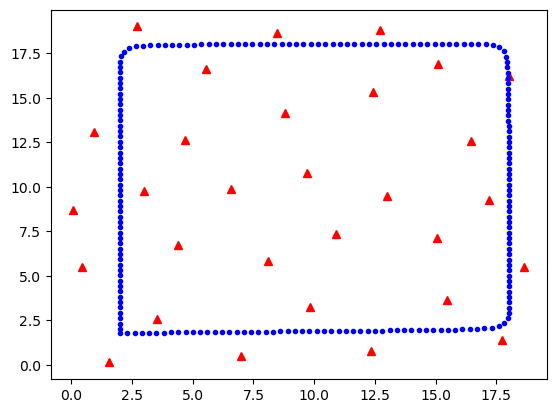

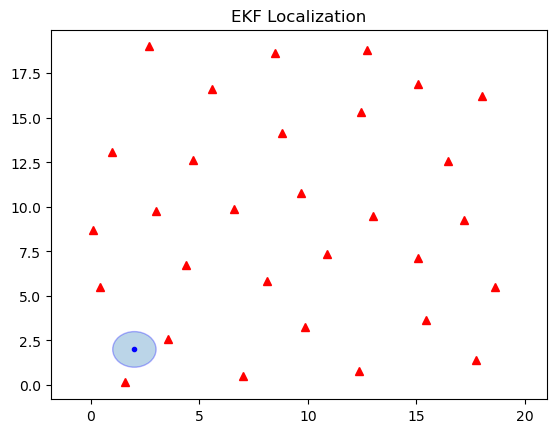

In [73]:
# Define the process noise covariance matrix (3x3)
sigma_x = 0.25  # Standard deviation for x position [m]
sigma_y = 0.25  # Standard deviation for y position [m]
sigma_theta = np.deg2rad(10)  # Standard deviation for orientation [rad]
# Create the process noise covariance matrix R as a diagonal matrix
R = np.diag(np.array([sigma_x, sigma_y, sigma_theta])**2)

# Define the observation noise covariance matrix (2x2)
sigma_r = 0.1  # Standard deviation for range measurement [m]
sigma_phi = np.deg2rad(5)  # Standard deviation for bearing measurement [rad]
# Create the observation noise covariance matrix Q as a diagonal matrix
Q = np.diag(np.array([sigma_r, sigma_phi])**2)

# Initial state estimate (mean) for the robot's position and orientation
mu = np.array([2, 2, np.pi / 2]).T  # [x, y, theta]

# Initial uncertainty (covariance) in the state estimate
S = np.array([[1, 0, 0],    # Variance in x position
              [0, 1, 0],    # Variance in y position
              [0, 0, np.pi / 3]])  # Variance in orientation

# Create a figure to visualize the map and the state
plt.figure()
plot_state(mu, S, M)  # Plot the state with mean mu and covariance S on the map M

In [ ]:
mu=mu.reshape(3,1)
est_traj=[[mu[0][0],mu[1][0]]]
for i in range(1,len(data['odom'])):
    u=[data['odom'][i-1],data['odom'][i]]
    z=data['z'][i]
    mu_pred,S_pred=ekf_predict(mu,S,u,R)
    mu,S=ekf_correct(mu_pred,S_pred,z,M,Q)
    est_traj.append([mu[0][0],mu[1,0]])


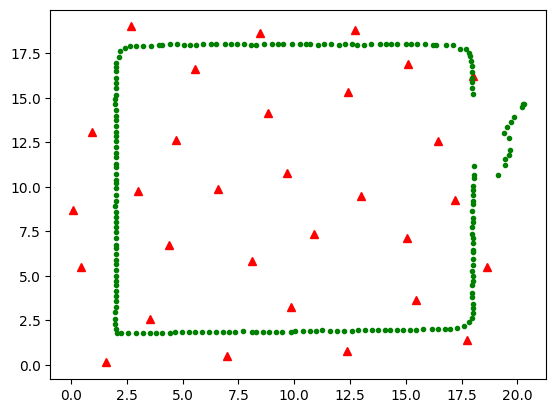

In [81]:
plt.figure(1)
plt.plot(M[:,0],M[:,1],'^r')

for i in range(0,len(est_traj),10):
    plt.plot(est_traj[i][0],est_traj[i][1],'.g')

# EKF-Based Robot Localization Tool

## Overview
This project implements an Extended Kalman Filter (EKF) for robot localization using odometry and sensor data. The tool provides functionalities for prediction, correction, and visualization of the estimated robot trajectory. It processes landmark-based observations and odometry readings to estimate the robot's pose over time.

## Table of Contents
- [Installation](#installation)
- [Usage](#usage)
- [Components](#components)
- [Theory](#theory)
- [Examples](#examples)

## Installation

### Prerequisites
- Python 3.8+
- NumPy
- Matplotlib
- Pickle

### Setup
```bash
# Install required packages
pip install numpy matplotlib
```

## Usage

### Load Dataset
```python
import pickle
import numpy as np
import matplotlib.pyplot as plt

data = pickle.load(open("dataset_2d_landmarks.p", "rb"))
M = data['M']  # Landmark coordinates
gt_traj = data['gt']  # Ground truth trajectory
```

### EKF Prediction
```python
from ekf_module import ekf_predict

# Define initial state and covariance
mu = np.array([2, 2, np.pi / 2]).T
P = np.array([[1, 0, 0], [0, 1, 0], [0, 0, np.pi/3]])

# Perform EKF prediction
odom_10 = data['odom'][10]
x_pred, P_pred = ekf_predict(mu, P, odom_10)
```

### EKF Correction
```python
from ekf_module import ekf_correct

# Get observation at timestamp 10
z_10 = data['z'][10]

# Perform EKF correction
mu_updated, P_updated = ekf_correct(x_pred, P_pred, z_10, M)
```

### Visualization
```python
plt.figure()
plt.plot(M[:,0], M[:,1], '^r')  # Plot landmarks
plt.plot(gt_traj[:,0], gt_traj[:,1], '.b')  # Plot ground truth trajectory
plt.show()
```

## Components

### `ekf_predict`
Implements the prediction step of the Extended Kalman Filter (EKF):
- Uses odometry data to predict the next state
- Computes the Jacobian of the motion model
- Updates the covariance matrix accordingly

### `ekf_correct`
Implements the correction step of the EKF:
- Uses landmark observations to refine the estimated pose
- Computes the Kalman gain
- Updates the state and covariance based on measurements

### `ekf_localization`
Main procedure for EKF-based localization:
- Recursively updates the state using odometry and sensor data
- Tracks the robot's estimated trajectory
- Plots the estimated pose over time

## Theory

### EKF Prediction Step
```
x' = f(x, u)
P' = G P G^T + R
```
Where:
- `x'` is the predicted state
- `P'` is the predicted covariance
- `G` is the Jacobian of the motion model
- `R` is the process noise covariance

### EKF Correction Step
```
y = z - h(x')
S = H P' H^T + Q
K = P' H^T S^-1
x = x' + Ky
P = (I - KH) P'
```
Where:
- `y` is the measurement residual
- `H` is the Jacobian of the observation model
- `K` is the Kalman gain
- `Q` is the measurement noise covariance

## Examples

### Running EKF Localization
```python
from ekf_module import ekf_localization

mu, P = ekf_localization(data, initial_state, initial_covariance)
plt.figure()
plot_state(mu, P, M)
plt.show()
```

